<a href="https://colab.research.google.com/github/lisatwyw/vivarium/blob/main/StyleNeuralTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



From:  
https://github.com/pytorch/xla/blob/master/contrib/colab/style_transfer_inference.ipynb



In [1]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'


In [2]:
!pip install cloud-tpu-client==0.10 torch==1.11.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 152.9 MB 31 kB/s 
     |████████████████████████████████| 57 kB 2.8 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.11
    Uninstalling google-api-python-client-1.12.11:
      Successfully uninstalled google-api-python-client-1.12.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.315 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.


In [4]:
from google.colab.patches import cv2_imshow
import cv2
import sys

# Configures repo in local colab fs
REPO_DIR = '/demo'
%mkdir -p "$REPO_DIR"
%cd "$REPO_DIR" 
%rm -rf examples
!git clone https://github.com/pytorch/examples.git 
%cd "$REPO_DIR/examples/fast_neural_style"

# Download pretrained weights for styles
!python download_saved_models.py
%cd "$REPO_DIR/examples/fast_neural_style/neural_style"


## Creates pre-trained style networks
import argparse
import os
import sys
import time
import re

import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu
import utils
from transformer_net import TransformerNet
from vgg import Vgg16

# Acquires the XLA device (a TPU core)
device = xm.xla_device()

# Loads pre-trained weights
rain_princess_path = '../saved_models/rain_princess.pth'
candy_path = '../saved_models/candy.pth'
mosaic_path = '../saved_models/mosaic.pth'
udnie_path = '../saved_models/udnie.pth'

# Loads the pre-trained weights into the fast neural style transfer
# network architecture and puts the network on the Cloud TPU core.
def load_style(path):
  with torch.no_grad():
    model = TransformerNet()
    state_dict = torch.load(path)
    # filters deprecated running_* keys from the checkpoint
    for k in list(state_dict.keys()):
        if re.search(r'in\d+\.running_(mean|var)$', k):
            del state_dict[k]
    model.load_state_dict(state_dict)
    return model.to(device)

# Creates each fast neural style transfer network
rain_princess = load_style(rain_princess_path)
candy = load_style(candy_path)
mosaic = load_style(mosaic_path)
udnie = load_style(udnie_path)

/demo
Cloning into 'examples'...
remote: Enumerating objects: 3427, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 3427 (delta 4), reused 10 (delta 0), pack-reused 3408
Receiving objects: 100% (3427/3427), 40.34 MiB | 15.23 MiB/s, done.
Resolving deltas: 100% (1685/1685), done.
/demo/examples/fast_neural_style
100% 23.9M/23.9M [00:00<00:00, 92.8MB/s]
/demo/examples/fast_neural_style/neural_style


--2022-07-12 00:11:43--  https://cdn.pixabay.com/photo/2019/06/11/15/42/corgi-face-4267312__480.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 172.64.150.12, 104.18.37.244, 2606:4700:4400::6812:25f4, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|172.64.150.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78473 (77K) [image/jpeg]
Saving to: ‘content.jpg’

content.jpg         100%[===================>]  76.63K  --.-KB/s    in 0.01s   

2022-07-12 00:11:43 (5.72 MB/s) - ‘content.jpg’ saved [78473/78473]



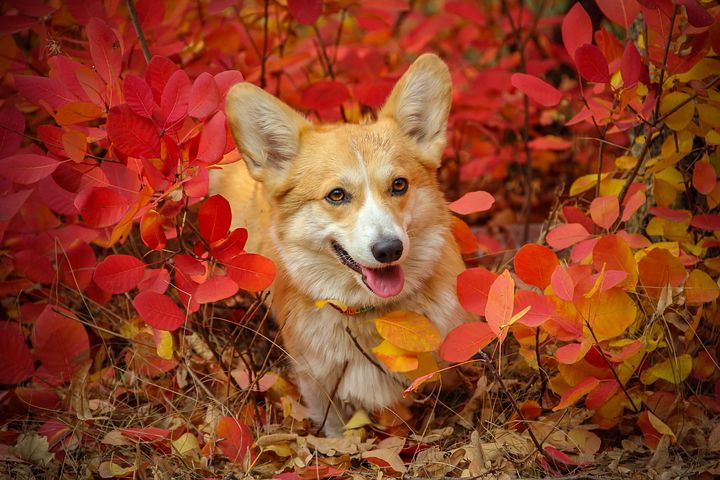

In [5]:
#@markdown ### Image URL (right click -> copy image address):
content_image_url = 'https://cdn.pixabay.com/photo/2019/06/11/15/42/corgi-face-4267312__480.jpg' #@param {type:"string"}
content_image = 'content.jpg'
!wget -O "$content_image" "$content_image_url"
RESULT_IMAGE = '/tmp/result.jpg'
!rm -f "$RESULT_IMAGE"
img = cv2.imread(content_image, cv2.IMREAD_UNCHANGED)

content_image = utils.load_image(content_image, scale=None)
content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
content_image = content_transform(content_image)
content_image = content_image.unsqueeze(0).to(device)

cv2_imshow(img)

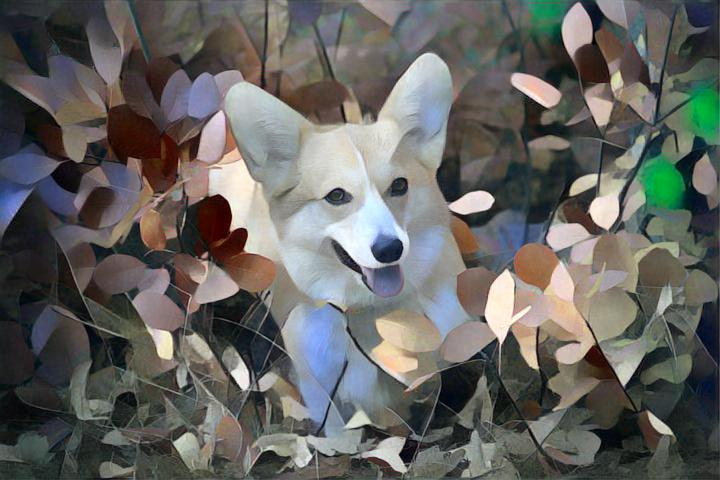

In [8]:
with torch.no_grad():
  output = rain_princess(content_image)
  # output = candy(content_image)
  # output = mosaic(content_image)
  output = udnie(content_image)


utils.save_image(RESULT_IMAGE, output[0].cpu())
img = cv2.imread(RESULT_IMAGE, cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

